In [11]:
import numpy as np
import torch
from pytorch_lightning import Trainer,seed_everything,LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import src.cnn as cnn
import torchvision.transforms as transforms
import importlib
import os
import matplotlib.pyplot as plt


In [6]:
os.chdir("..")
os.getcwd()

'/Users/coulaud/Documents/DL-normalization'

In [28]:
ls results/wandb/cnn/nemo_bnd_10_3k/checkpoints

epoch=3116-val_loss=0.00001.ckpt  last.ckpt


In [29]:
importlib.reload(cnn)
model = cnn.CNN.load_from_checkpoint("results/wandb/cnn/nemo_bnd_10_3k/checkpoints/epoch=3116-val_loss=0.00001.ckpt")
data_dir = "data/processed/nemo_bnd_fixed/"

In [ ]:
f = open(data_dir+"norms_std_mean.txt")
lines = f.readlines()
assert len(lines) == 2, f"len {len(lines)}"
std = float(lines[0])
mean = float(lines[1])
f.close()

### Bias on 1 sample

In [30]:
X = np.load(data_dir+"train/X/NORSSH_BND_PERTEN2.npz")['arr_0']
Y = np.load(data_dir+"train/Y/NORSSH_BND_PERTEN2_norm_coeffs.npz")['arr_0']
Y = transforms.CenterCrop([290, 360])(torch.from_numpy(Y)).numpy()
X = torch.from_numpy(X[np.newaxis,:]).float()
X = X[:,:,:-10,:]

In [57]:
print("mean: ",np.mean(np.abs(np.ma.masked_array(np.mean(eps,axis=0), mask))))
print("max: ",np.max(np.abs(np.ma.masked_array(np.mean(eps,axis=0), mask))))

mean:  0.0016586822495805935
max:  0.05695298863840555


In [31]:
mask = np.where(Y==0,True,False)
Y = Y*std + mean
Y_pred = model.forward(X).detach()*std + mean
Y_pred =  transforms.CenterCrop([290, 360])(Y_pred).numpy()
Y2 = np.power(Y,2)
eps = (np.power(Y_pred,2) - Y2)/Y2
eps = np.ma.masked_array(eps, mask)

print("mean: ",np.mean(np.abs(eps)[np
                                   .nonzero(eps)]))
print("max: ",np.max(eps))
print("min: ",np.min(eps))

mean:  0.0016586822495805933
max:  0.05695298863840555
min:  -0.054915926344592476


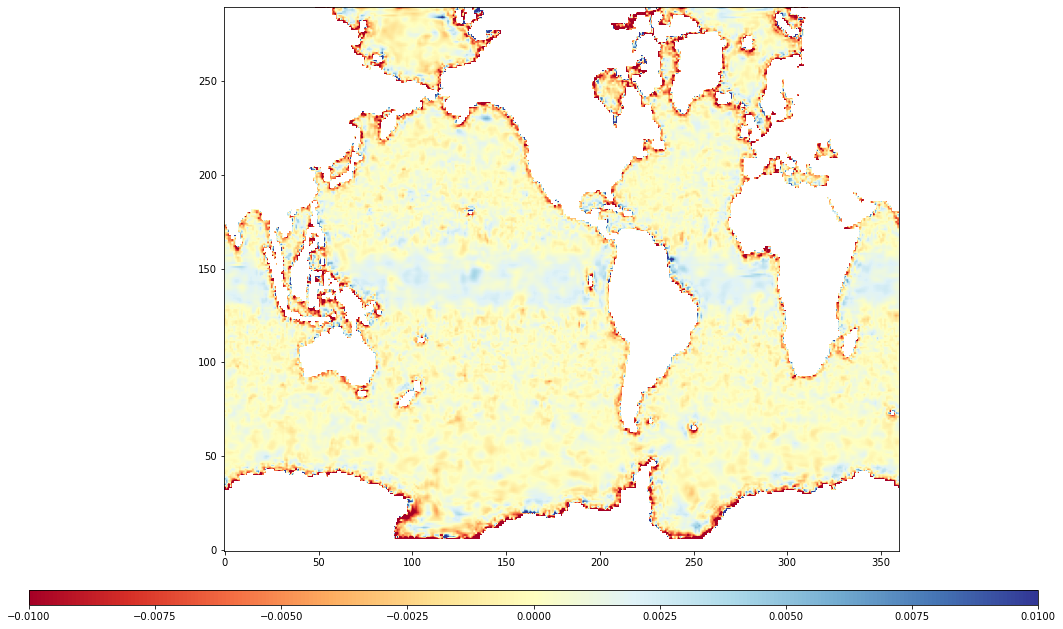

In [60]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(eps[0,0,:,:],origin="lower",vmin=-0.015,vmax=0.015,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

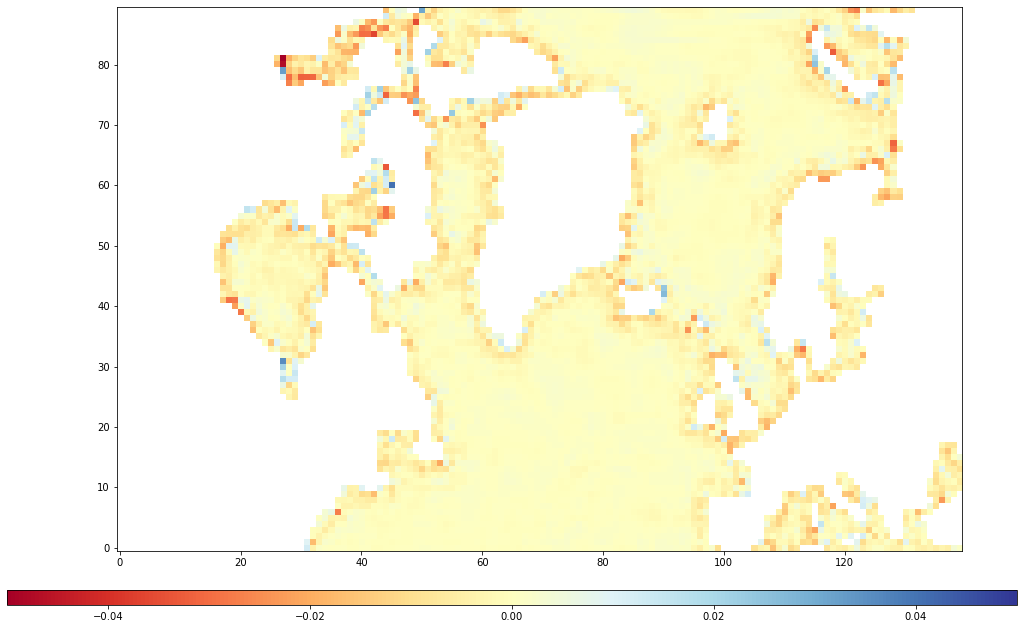

max:  0.04031842365113689
min:  -0.05321684513559629


In [51]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(eps[0,0,200:290,180:320],origin="lower",vmin=-0.05,vmax=0.05,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()
print("max: ",np.max(eps[0,0,200:290,180:320]))
print("min: ",np.min(eps[0,0,200:290,180:320]))

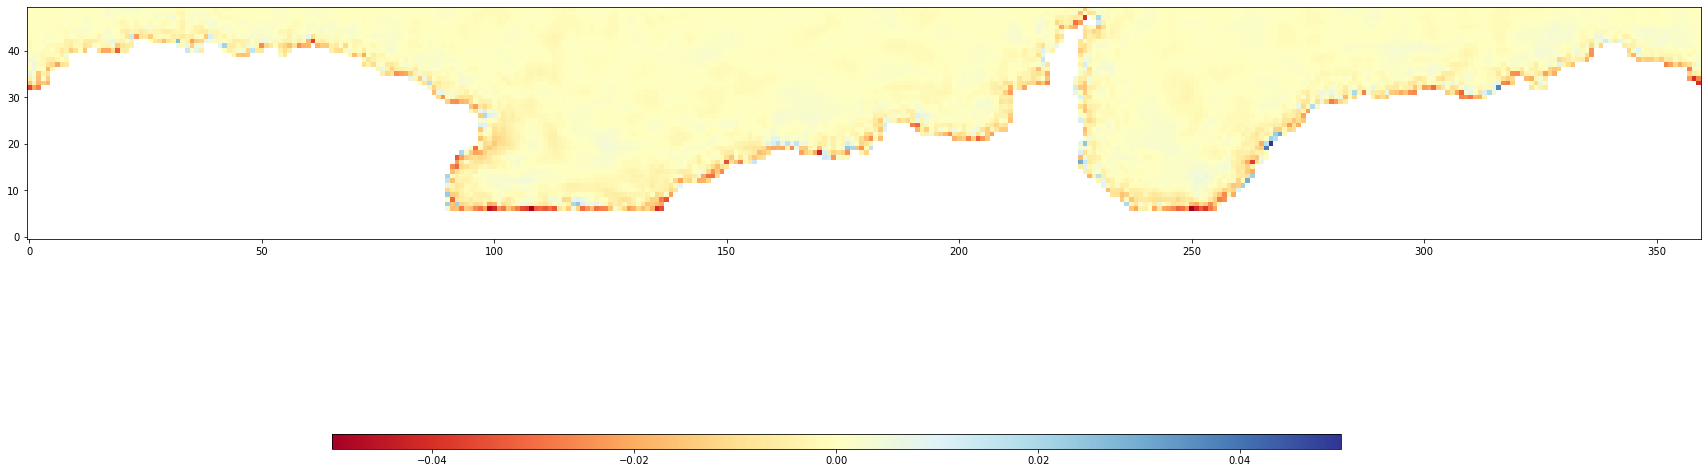

max:  0.051311218355678374
min:  -0.054915926344592476


In [52]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(eps[0,0,0:50,:],origin="lower",vmin=-0.05,vmax=0.05,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()
print("max: ",np.max(eps[0,0,0:50,:]))
print("min: ",np.min(eps[0,0,0:50,:]))

### Training bias

In [55]:
epsF = np.empty((len(os.listdir(data_dir+"train/X/")),290,360))
for i,file_list in enumerate(os.listdir(data_dir+"train/X/")):
    X=np.load(data_dir+"train/X/"+file_list)['arr_0']
    X=torch.from_numpy(X[np.newaxis,:]).float()
    X = X[:,:,:-10,:]
    Y=np.load(data_dir+"train/Y/"+ file_list.split(".")[0]+"_norm_coeffs.npz")['arr_0']
    Y = transforms.CenterCrop([290, 360])(torch.from_numpy(Y)).numpy()
    if i==0:
        mask = np.where(Y==0,True,False) 
    Y = Y*std + mean
    Y_pred = model.forward(X).detach()*std + mean
    Y_pred =  transforms.CenterCrop([290, 360])(Y_pred).numpy()
    aux = (Y_pred**2 - Y**2)/Y**2
    epsF[i,:,:] = np.ma.masked_array(aux, mask)

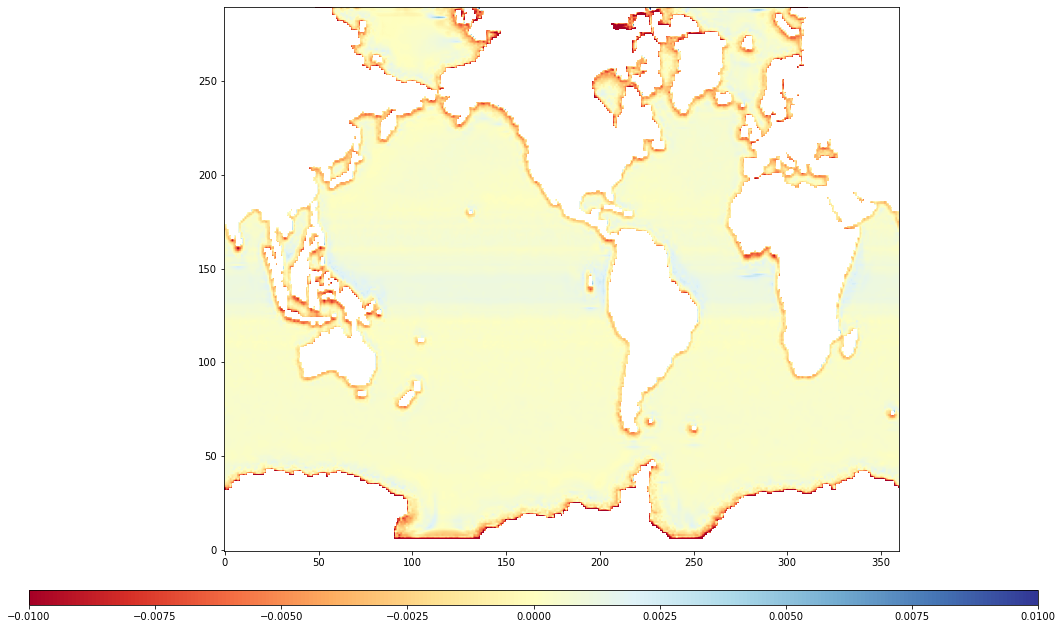

In [62]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(np.ma.masked_array(np.mean(epsF,axis=0), mask),origin="lower",vmin=-0.01,vmax=0.01,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

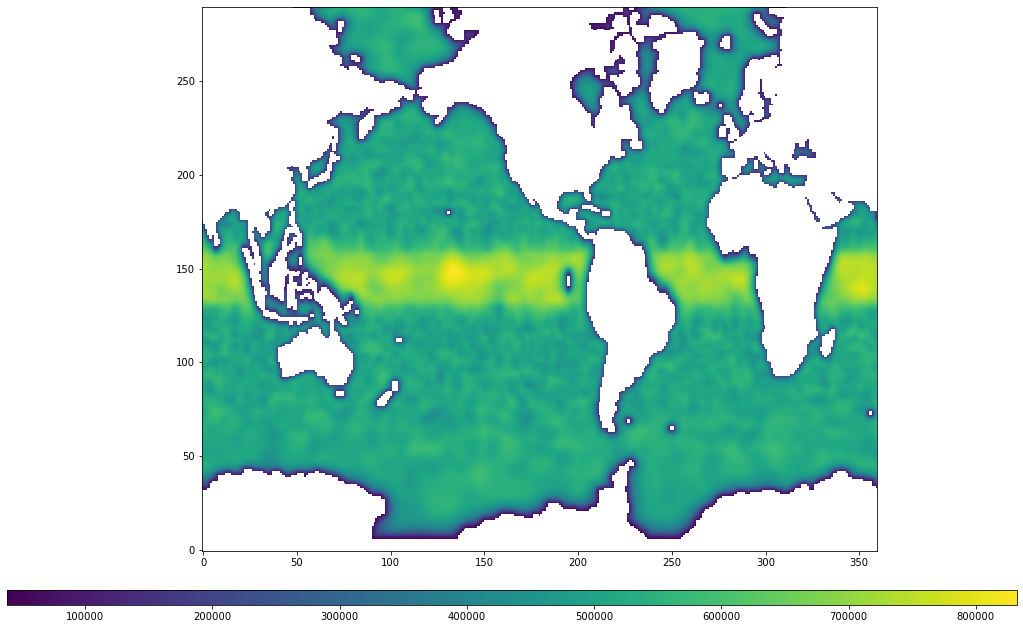

In [37]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(np.ma.masked_array(Y_pred, mask)[0,0,:,:],origin="lower")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

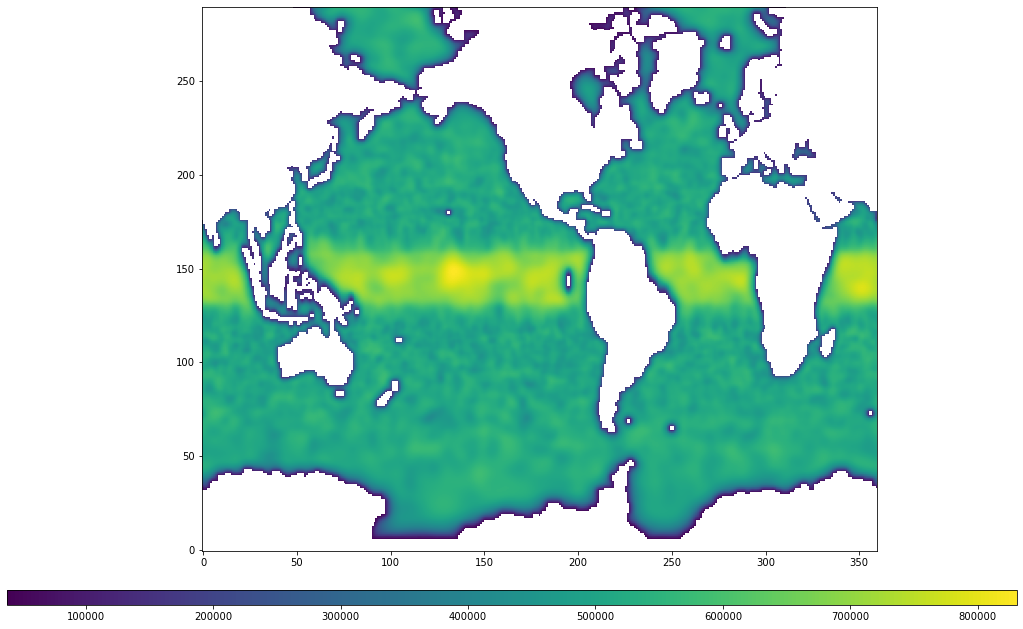

In [44]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(np.ma.masked_array(Y, mask),origin="lower")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

In [43]:
np.ma.masked_array(Y, mask).shape

(290, 360)